In [ ]:
# some packages are not installed by default in the Conda environment
%pip install tqdm gudhi EMD-signal giotto-tda

# Clustering EEG time series using persistent homology

## Data loading

In [31]:
import numpy as np
import pandas as pd
import os
import random
import gudhi as gd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

seed = 123
random.seed = seed

In [32]:
eeg_data = pd.read_csv('data/train_processed.csv')
eeg_data

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625
...,...,...,...,...,...,...,...,...,...
7308283,12,CPZ,251,2.716,a,S1 obj,61,co2a0000369,0.980469
7308284,12,CPZ,252,1.740,a,S1 obj,61,co2a0000369,0.984375
7308285,12,CPZ,253,1.251,a,S1 obj,61,co2a0000369,0.988281
7308286,12,CPZ,254,1.251,a,S1 obj,61,co2a0000369,0.992188


In [33]:
eeg_data = eeg_data[eeg_data['sensor position'] == 'CPZ']
eeg_data.shape

(119808, 9)

## Preprocessing, feature extraction and visualization methods

In [34]:
from gudhi import RipsComplex, EuclideanWitnessComplex, pick_n_random_points
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import PyEMD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from gtda.time_series import SingleTakensEmbedding

def apply_emd(signal, num_imfs=3):
    """Apply Empirical Mode Decomposition (EMD) to filter noise."""
    emd = PyEMD.EMD()
    imfs = emd(signal)
    if len(imfs) == 0:
        return signal
    return sum(imfs[-num_imfs-1:])

def takens_embedding(series, m, tau):
    """Reconstruct the phase space using Takens' embedding theorem."""
    embedded = SingleTakensEmbedding(parameters_type="fixed", dimension=m, time_delay=tau, n_jobs=-1).fit_transform(series)
    return embedded

def compute_persistence_diagram_rips(data, max_dim=2):
    """Compute the persistence diagram using Gudhi."""
    rips = RipsComplex(points=data)
    simplex_tree = rips.create_simplex_tree(max_dimension=max_dim)
    diag = simplex_tree.persistence()
    return diag

def maxmin_landmark_selection(data, num_landmarks):
    """Select landmarks using the maxmin algorithm."""
    # Randomly select the first landmark
    landmarks = [data[np.random.choice(len(data))]]

    for _ in range(1, num_landmarks):
        # Compute the minimum distance from each point to the selected landmarks
        distances = np.array([
            min(np.linalg.norm(point - landmark) for landmark in landmarks)
            for point in data
        ])

        # Select the point with the maximum of the minimum distances
        next_landmark = data[np.argmax(distances)]
        landmarks.append(next_landmark)

    return np.array(landmarks)

def compute_persistence_diagram_witness_complex(data, landmarks_ratio=0.1, max_dim=2):
    """Compute the persistence diagram using Lazy Witness complexes."""
    num_landmarks = max(1, int(len(data) * landmarks_ratio))
    # landmarks = pick_n_random_points(points=data, nb_points=num_landmarks)
    landmarks = maxmin_landmark_selection(data, num_landmarks)

    witness_complex = EuclideanWitnessComplex(witnesses=data, landmarks=landmarks)
    simplex_tree = witness_complex.create_simplex_tree(max_alpha_square=1, limit_dimension=max_dim)
    diag = simplex_tree.persistence()
    return diag

def extract_features(diagram, ratio=0.1):
    """Extract topological features from the persistence diagram."""
    features = []
    for dim in [0, 1]:
        lifetimes = [p[1][1] - p[1][0] for p in diagram if p[0] == dim and p[1][1] != float('inf')]
        if lifetimes:
            max_lifetime = max(lifetimes)
            relevant_holes = sum(1 for lifetime in lifetimes if lifetime >= ratio * max_lifetime)
            features.extend([
                len(lifetimes),          # Number of holes
                max_lifetime,            # Maximum lifetime
                relevant_holes,          # Number of relevant holes
                np.mean(lifetimes),      # Average lifetime
                np.sum(lifetimes),       # Total lifetime
            ])
        else:
            features.extend([0, 0, 0, 0, 0])  # Handle empty cases
    return features

def cluster_and_evaluate(features, labels):
    """Perform clustering and evaluate against ground truth labels."""
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=2, random_state=42)
    predicted_labels = kmeans.fit_predict(scaled_features)
    
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    mathews_corrcoef = matthews_corrcoef(labels, predicted_labels)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Mathews Correlation Coefficient: {mathews_corrcoef:.2f}")
    
    print(classification_report(labels, predicted_labels))
    
    cm = confusion_matrix(labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    return predicted_labels

def plot_time_series_and_attractor(signal, filtered_signal, embedded_data, subject_id):
    """Plot the original time series, the filtered time series, and its Takens embedding attractor."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot time series
    axes[0].plot(signal, label="Time Series", color="blue", linewidth=1)
    axes[0].set_title(f"Time Series (Subject {subject_id[0]}, Trial {subject_id[1]})")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Sensor Value")
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot filtered time series
    axes[1].plot(filtered_signal, label="Filtered Time Series", color="red", linewidth=1)
    axes[1].set_title(f"Filtered Time Series (Subject {subject_id[0]}, Trial {subject_id[1]})")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Sensor Value")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust attractor data scaling for better visibility
    embedded_data_normalized = (embedded_data - np.min(embedded_data, axis=0)) / (
        np.max(embedded_data, axis=0) - np.min(embedded_data, axis=0)
    )

    # Plot attractor in 2D
    axes[2].plot(
        embedded_data_normalized[:, 0],
        embedded_data_normalized[:, 1],
        label="Attractor",
        color="green",
        linewidth=1,
    )
    axes[2].set_xlabel("Dimension 1 (scaled)")
    axes[2].set_ylabel("Dimension 2 (scaled)")

    axes[2].set_title(f"Phase Space (Subject {subject_id[0]}, Trial {subject_id[1]})")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

def plot_persistence_diagram_and_barcode(diagram, subject_id):
    """Plot the persistence diagram and barcode for the given subject."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot persistence diagram
    gd.plot_persistence_diagram(diagram, axes=axes[0])
    axes[0].set_title(f"Persistence Diagram (Subject {subject_id[0]}, Trial {subject_id[1]})")

    # Plot persistence barcode
    gd.plot_persistence_barcode(diagram, axes=axes[1])
    axes[1].set_title(f"Persistence Barcode (Subject {subject_id[0]}, Trial {subject_id[1]})")

    plt.tight_layout()
    plt.show()

## Baseline method for clustering raw time series data using KMeans

100%|██████████| 468/468 [00:00<00:00, 9570.39it/s]
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Accuracy: 0.45
Precision: 0.67
Recall: 0.32
F1 Score: 0.43
Mathews Correlation Coefficient: 0.02
              precision    recall  f1-score   support

           0       0.35      0.69      0.46       160
           1       0.67      0.32      0.43       308

    accuracy                           0.45       468
   macro avg       0.51      0.51      0.45       468
weighted avg       0.56      0.45      0.44       468



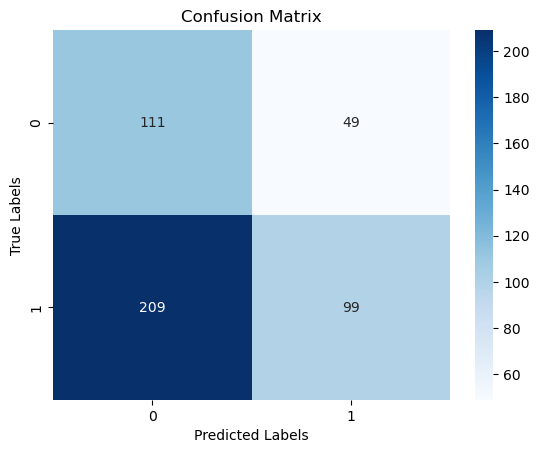

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,

In [35]:
# Extract raw time series data for each subject and trial
raw_features = []
raw_labels = []

for subject_id, group in tqdm(eeg_data.groupby(["name", "trial number"])):
  label = 1 if "a" in group["matching condition"].iloc[0] else 0 # 0 for alcoholic, 1 for control subjects
  raw_labels.append(label)
  
  signal = group["sensor value"].values
  raw_features.append(signal)

# Convert to numpy array and pad sequences to the same length
max_length = max(len(f) for f in raw_features)
raw_features_padded = np.array([np.pad(f, (0, max_length - len(f)), 'constant') for f in raw_features])

# Cluster and evaluate
cluster_and_evaluate(raw_features_padded, raw_labels)

## Clustering EEG time series using persistent homology

  0%|          | 0/468 [00:00<?, ?it/s]

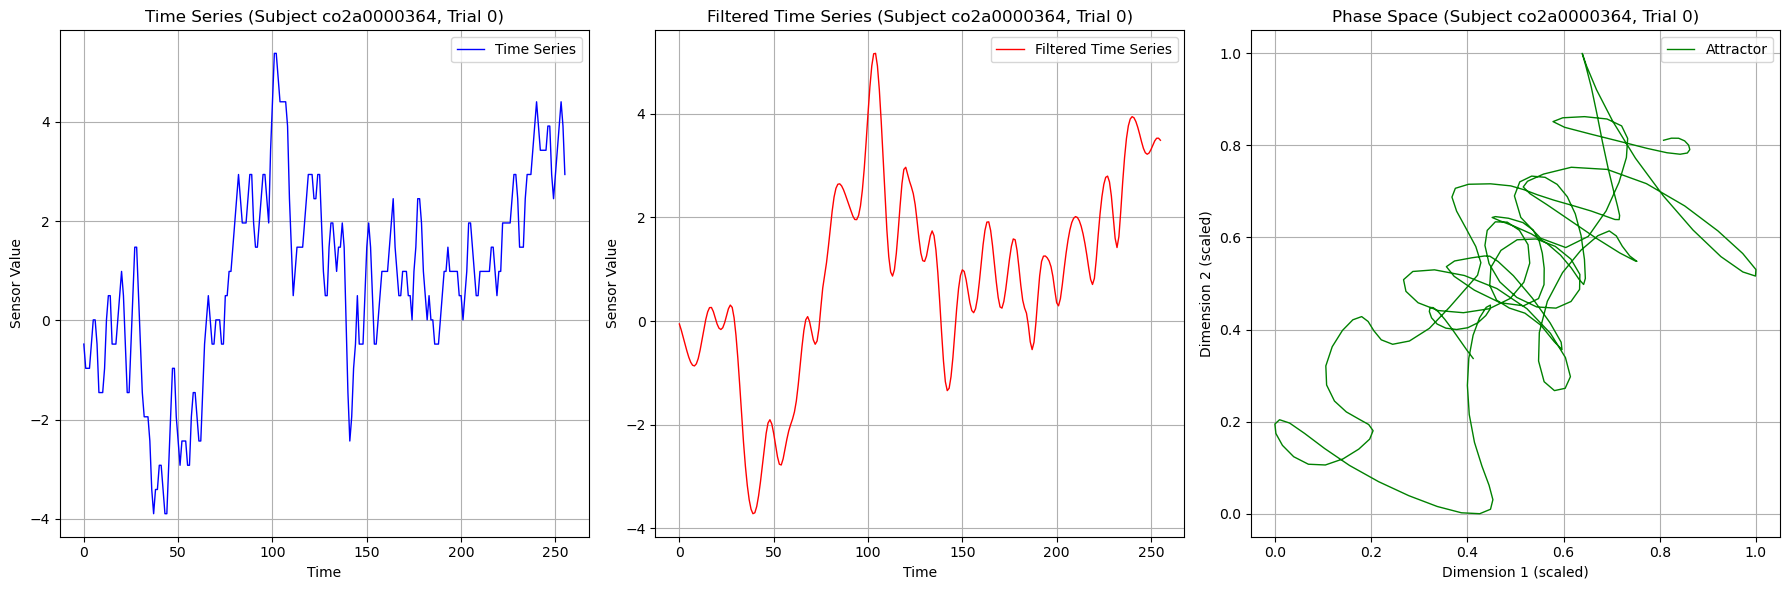

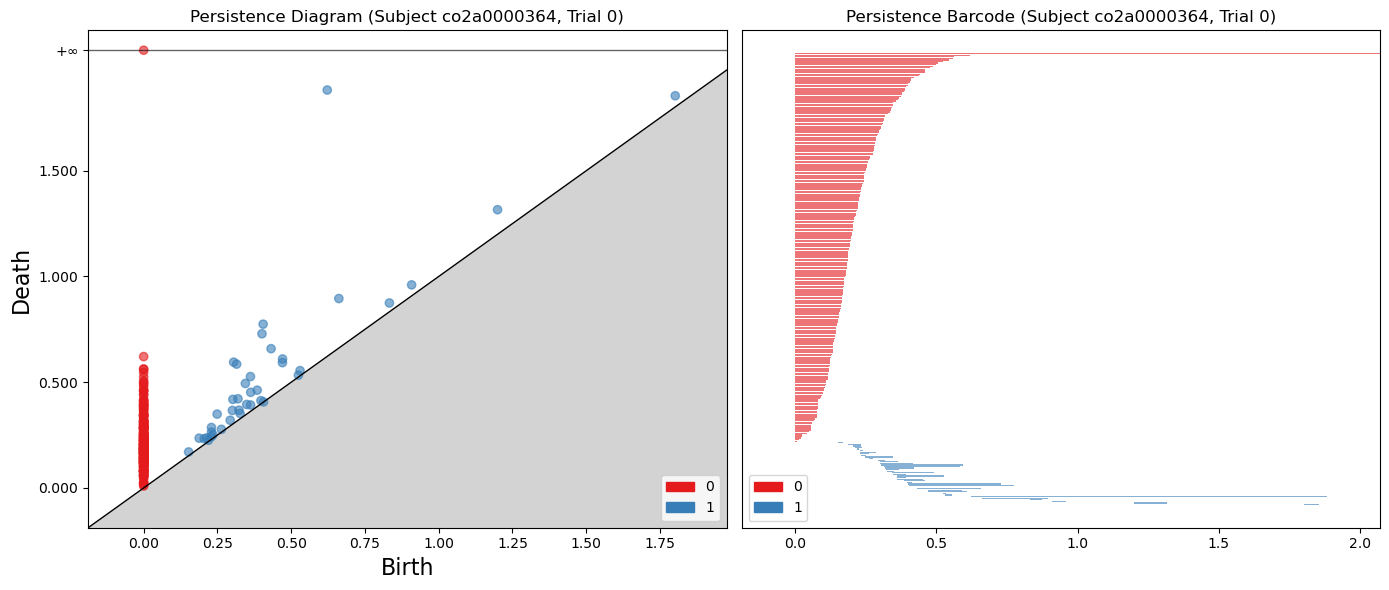

  6%|▋         | 30/468 [00:48<10:46,  1.48s/it]

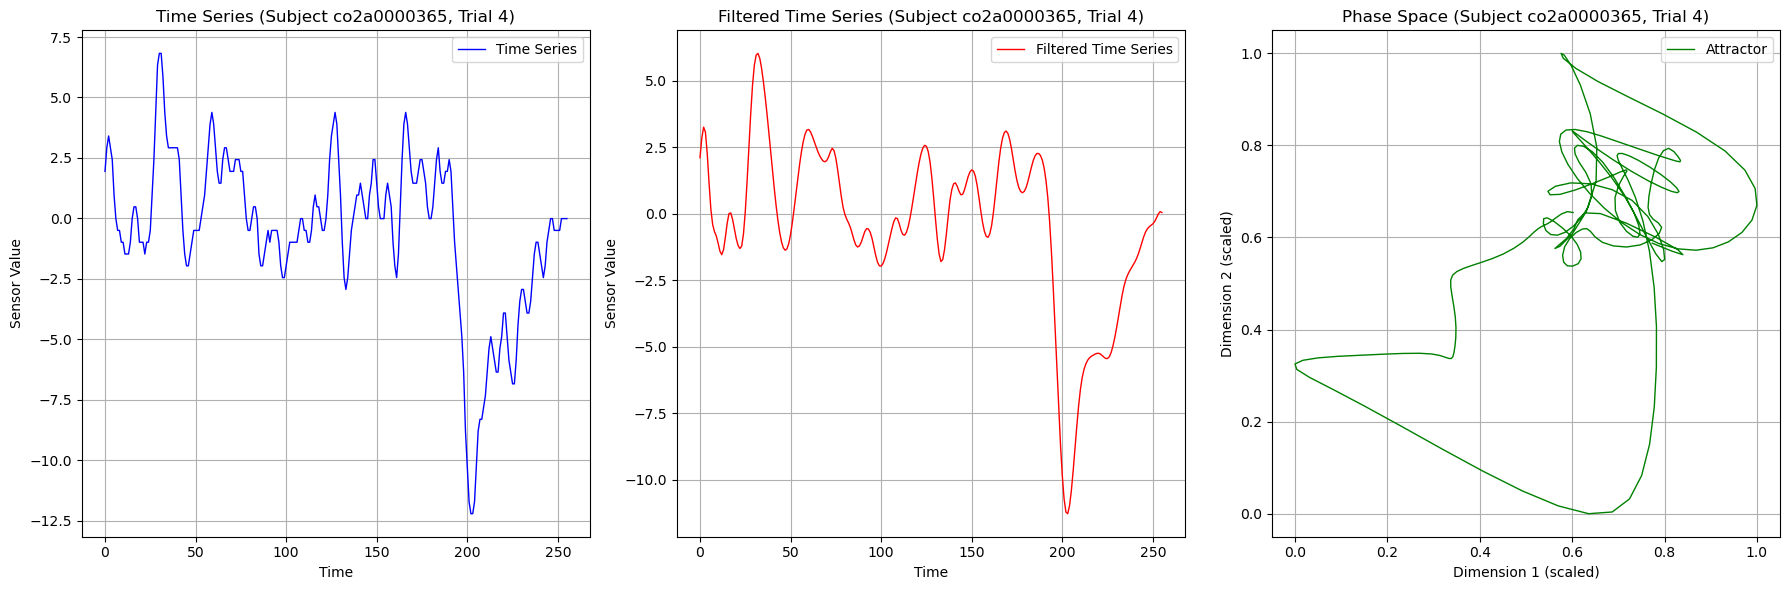

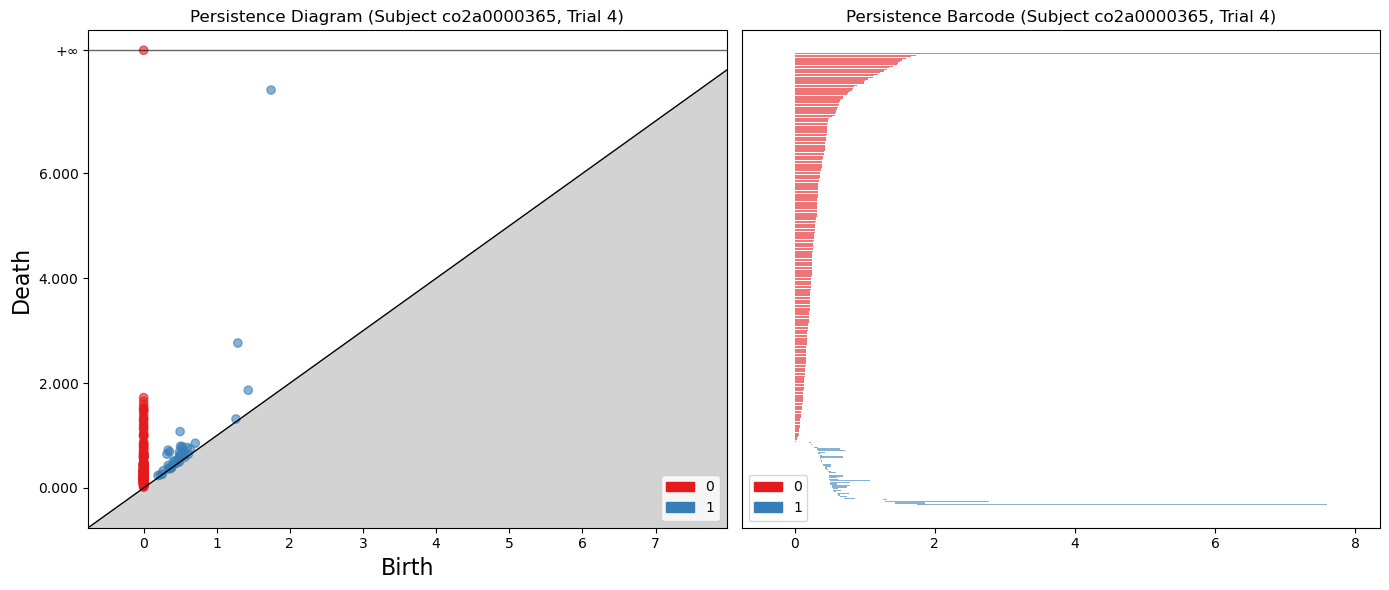

 13%|█▎        | 60/468 [01:29<09:20,  1.37s/it]

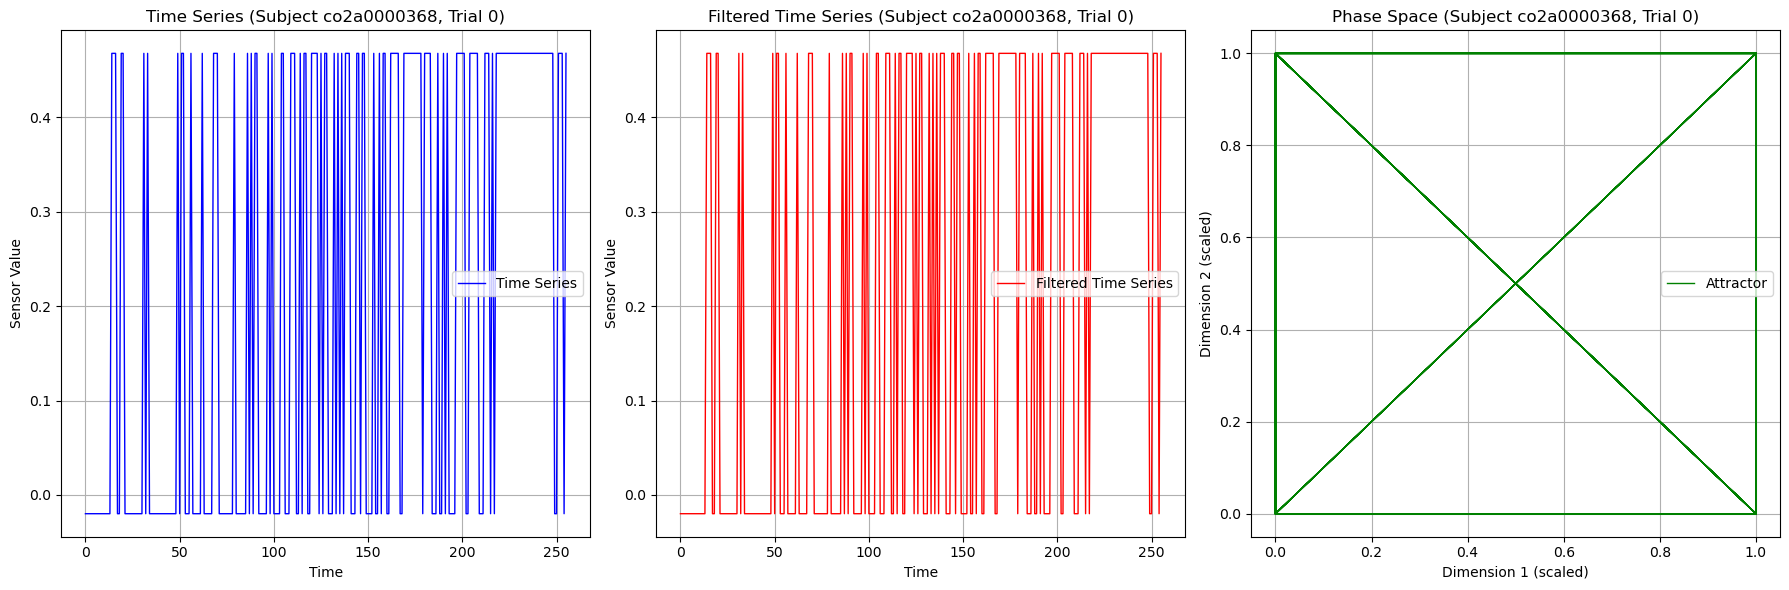

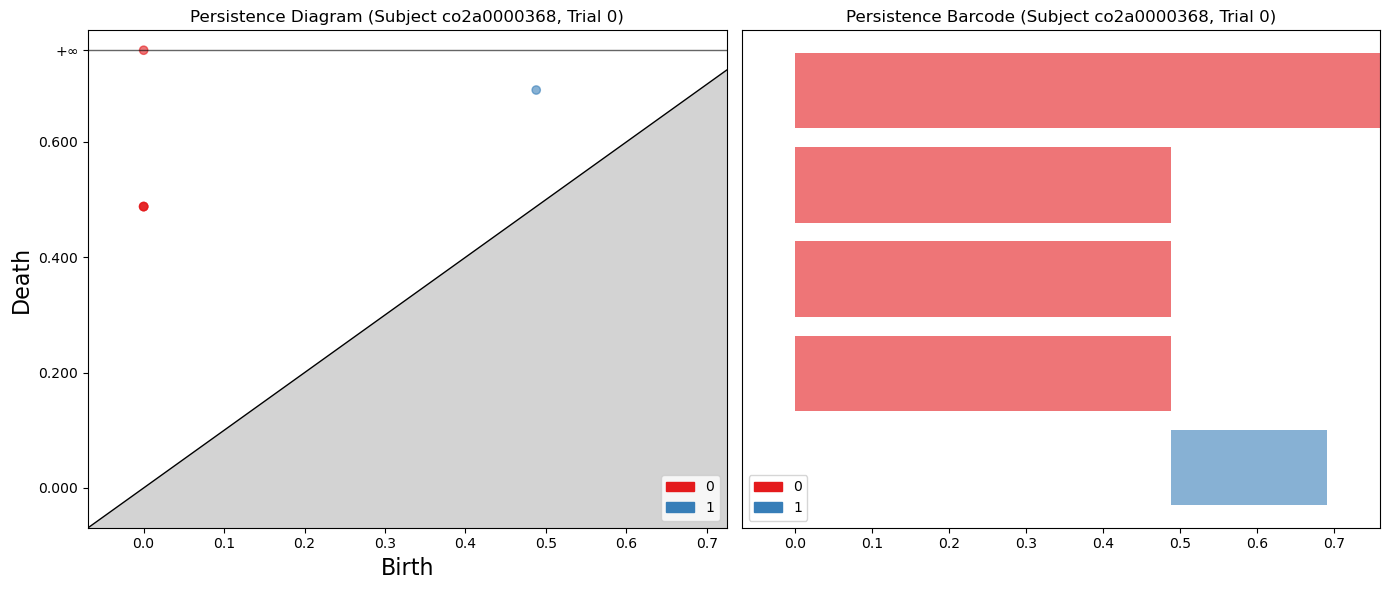

 19%|█▉        | 89/468 [02:10<08:56,  1.41s/it]

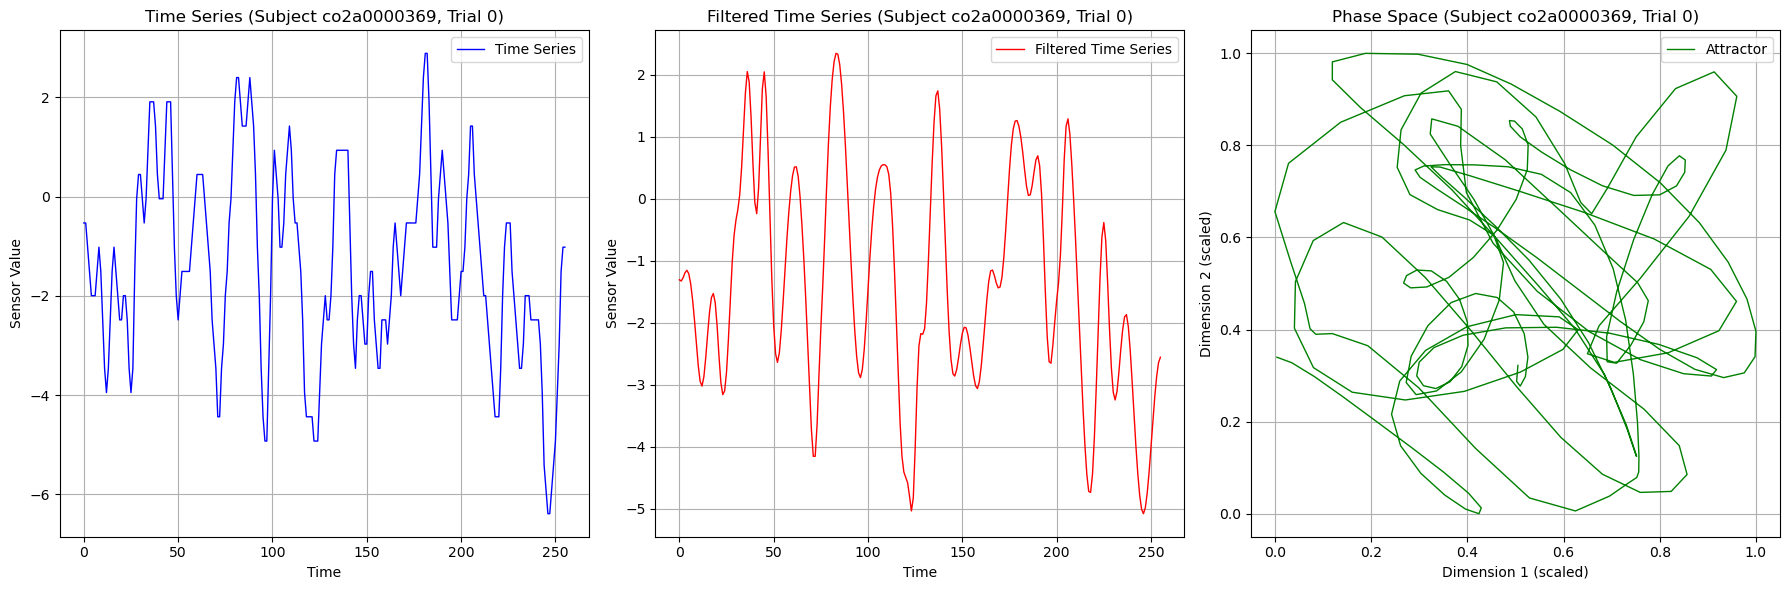

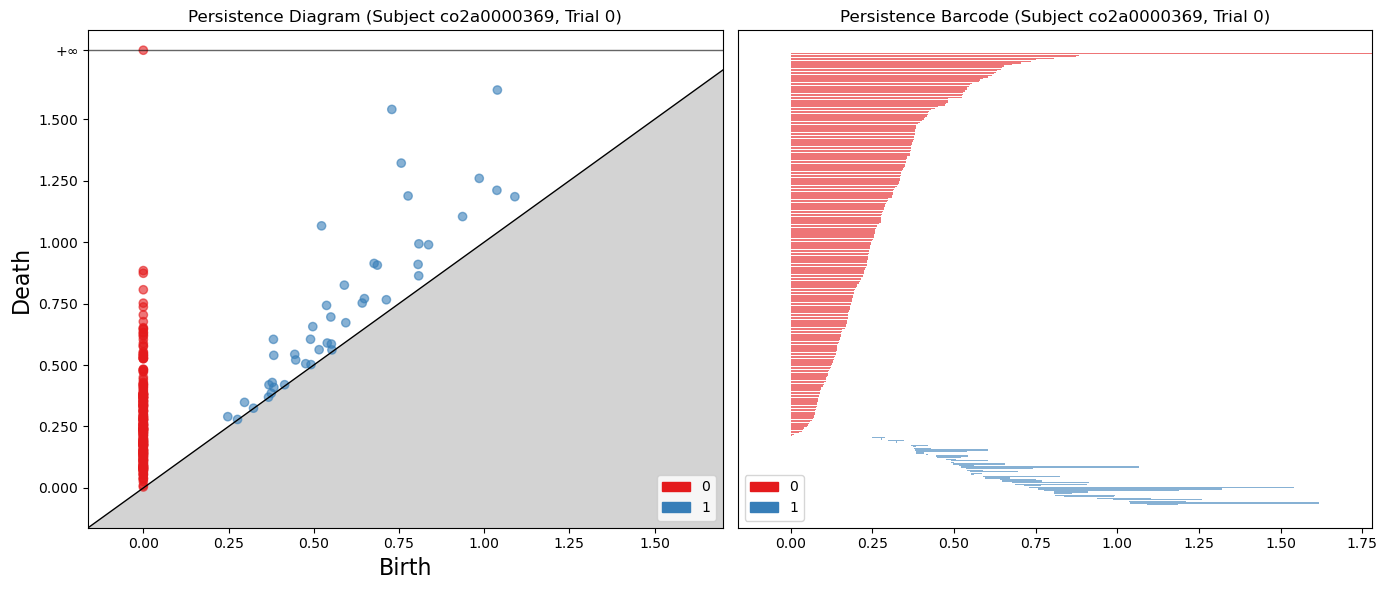

 25%|██▌       | 118/468 [02:48<06:58,  1.20s/it]

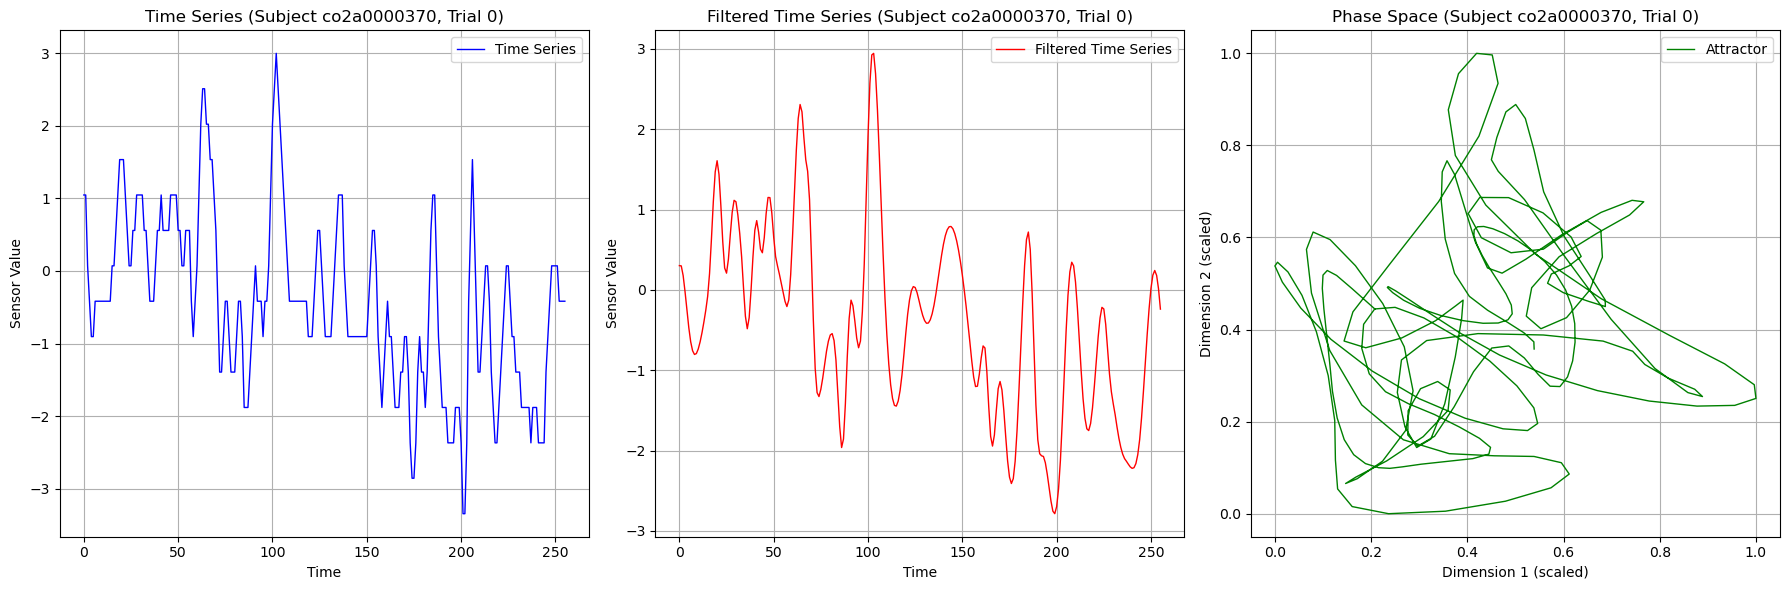

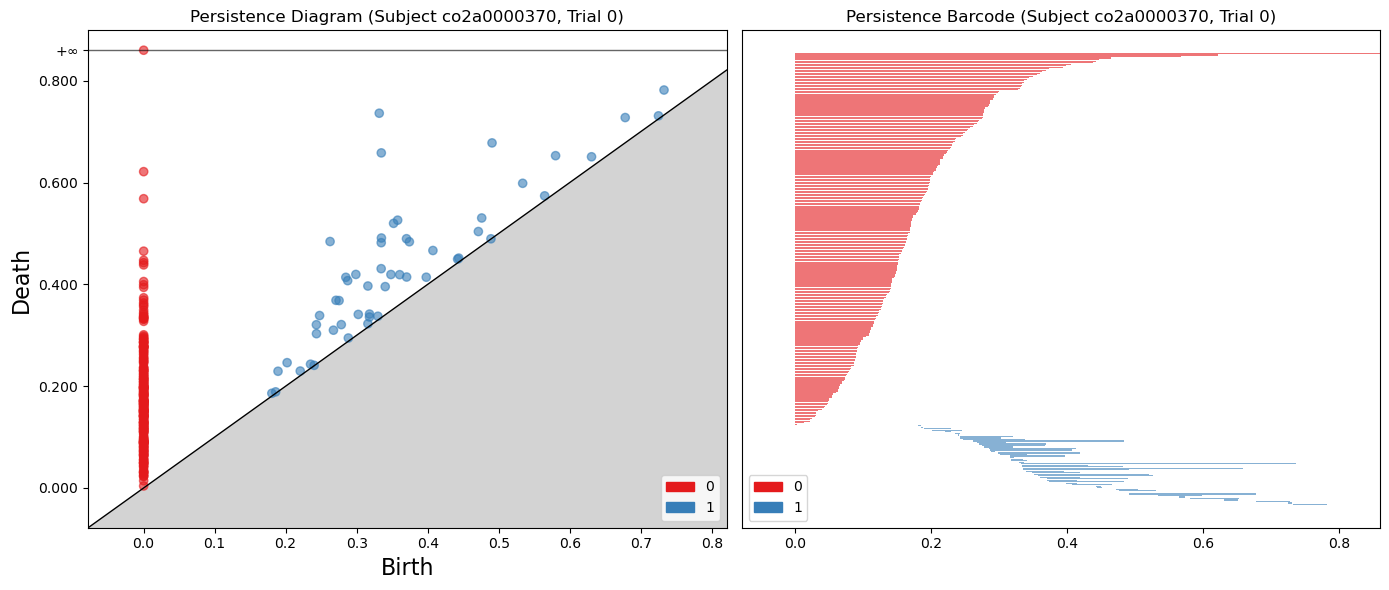

 31%|███▏      | 147/468 [03:27<07:05,  1.32s/it]

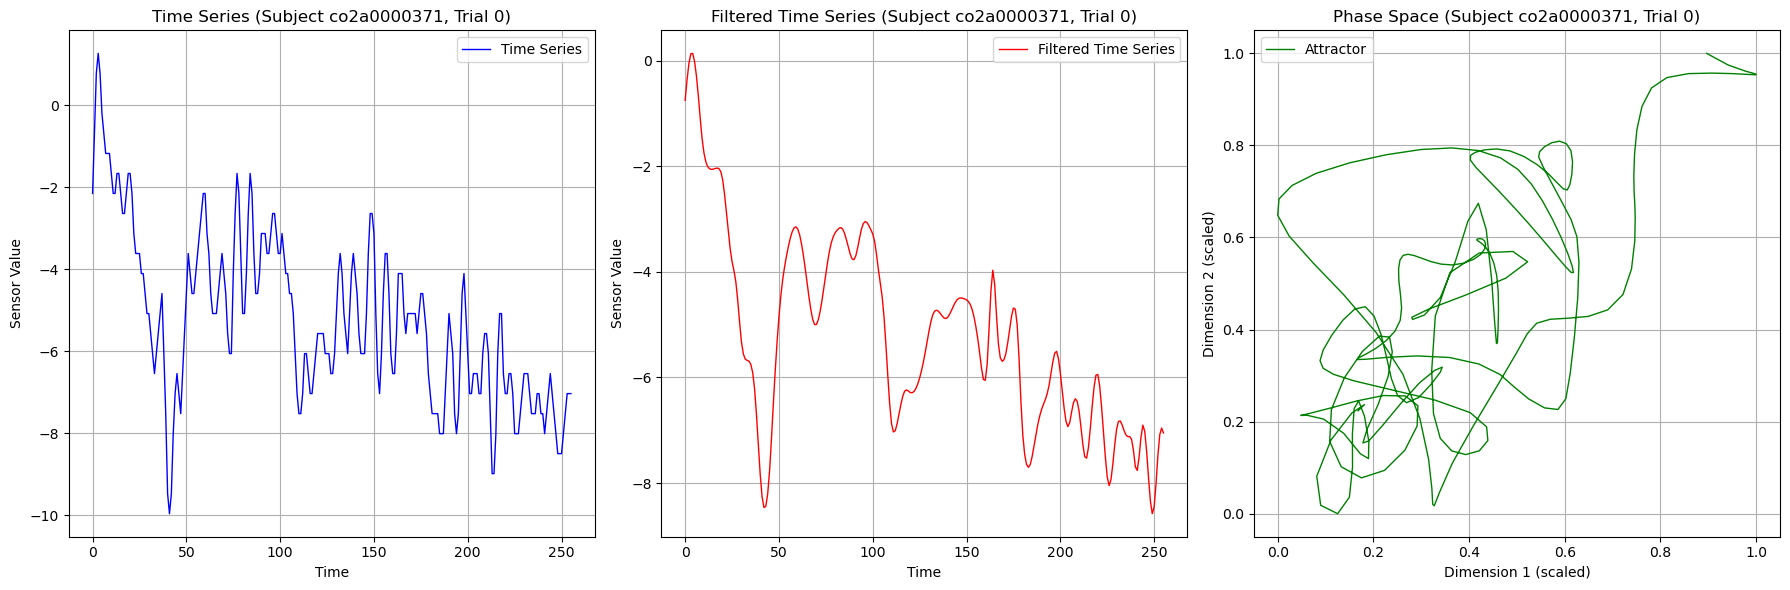

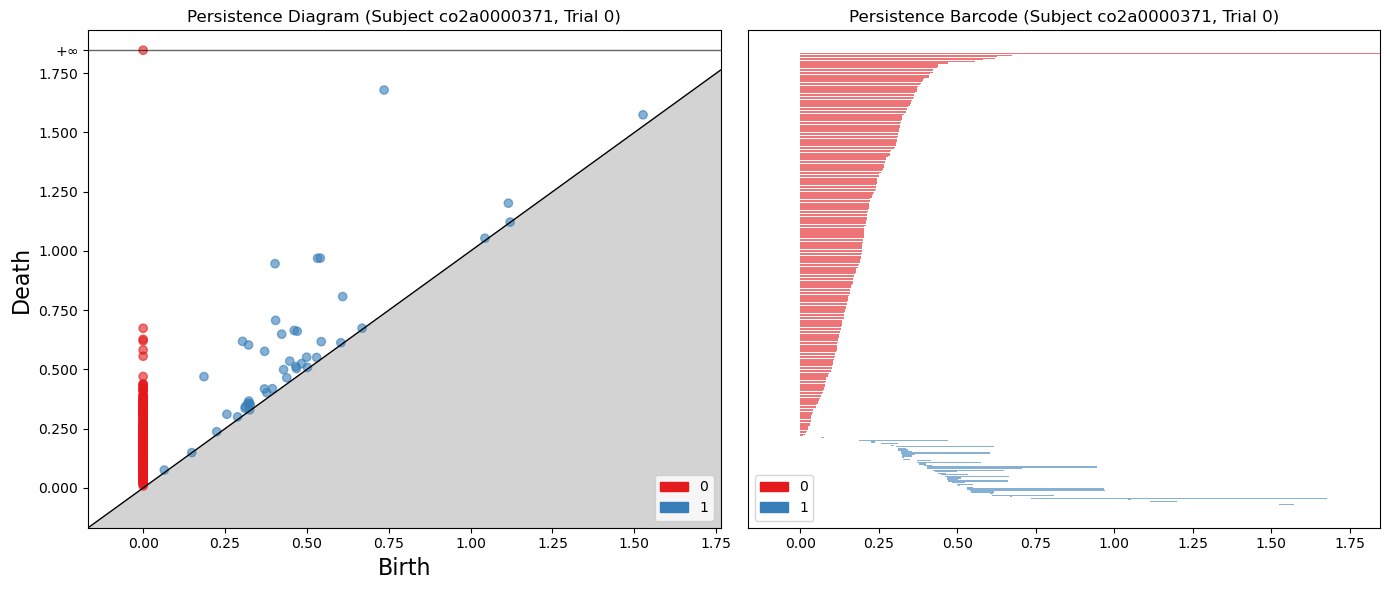

 38%|███▊      | 176/468 [04:04<06:03,  1.25s/it]

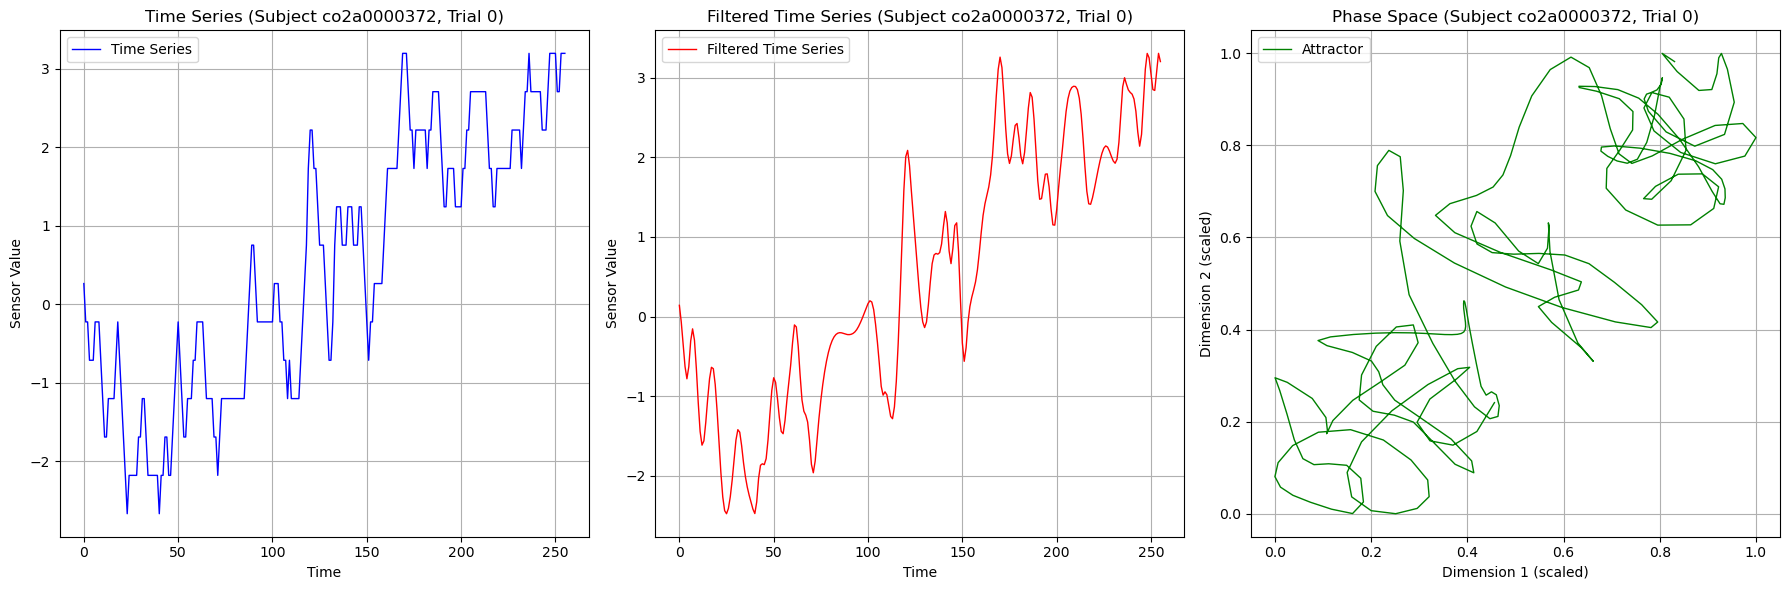

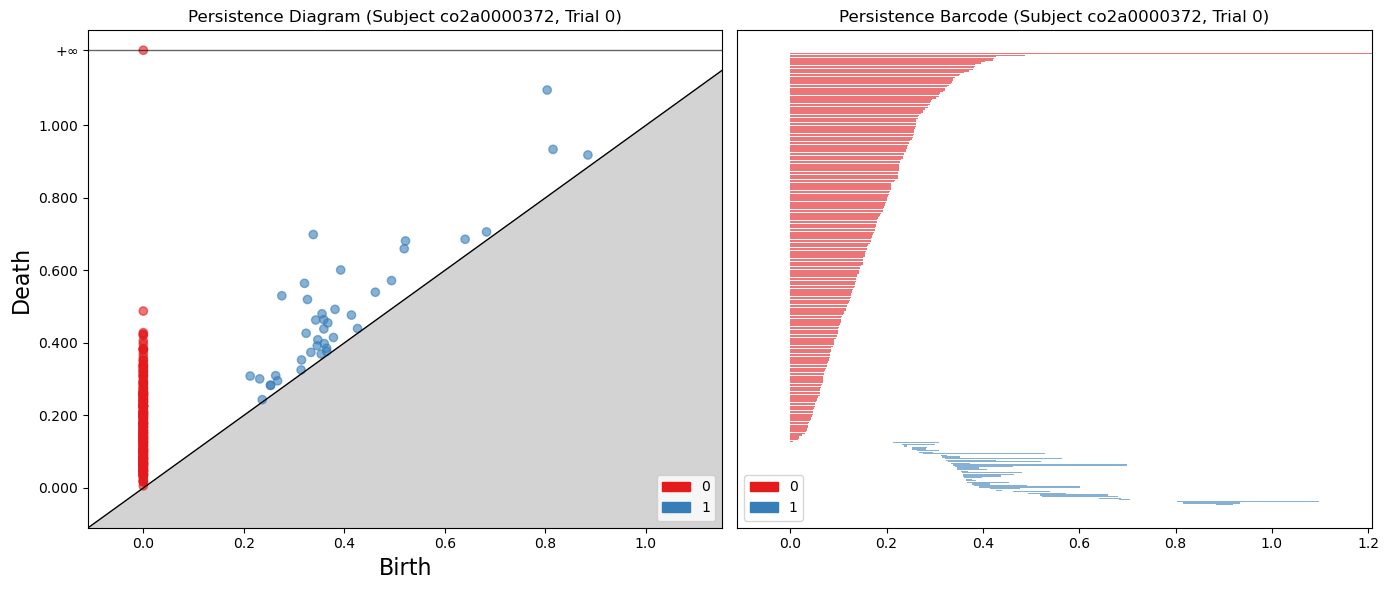

 44%|████▍     | 205/468 [04:46<05:47,  1.32s/it]

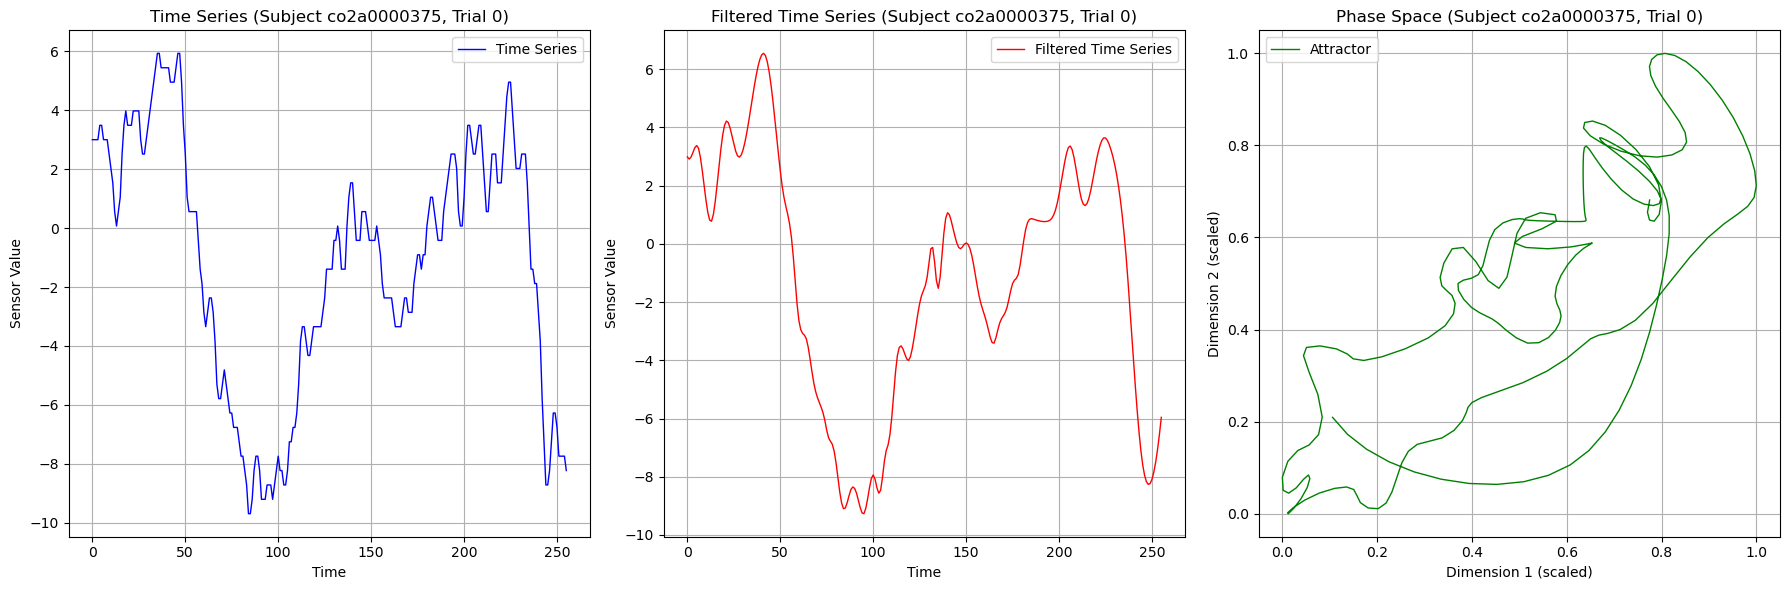

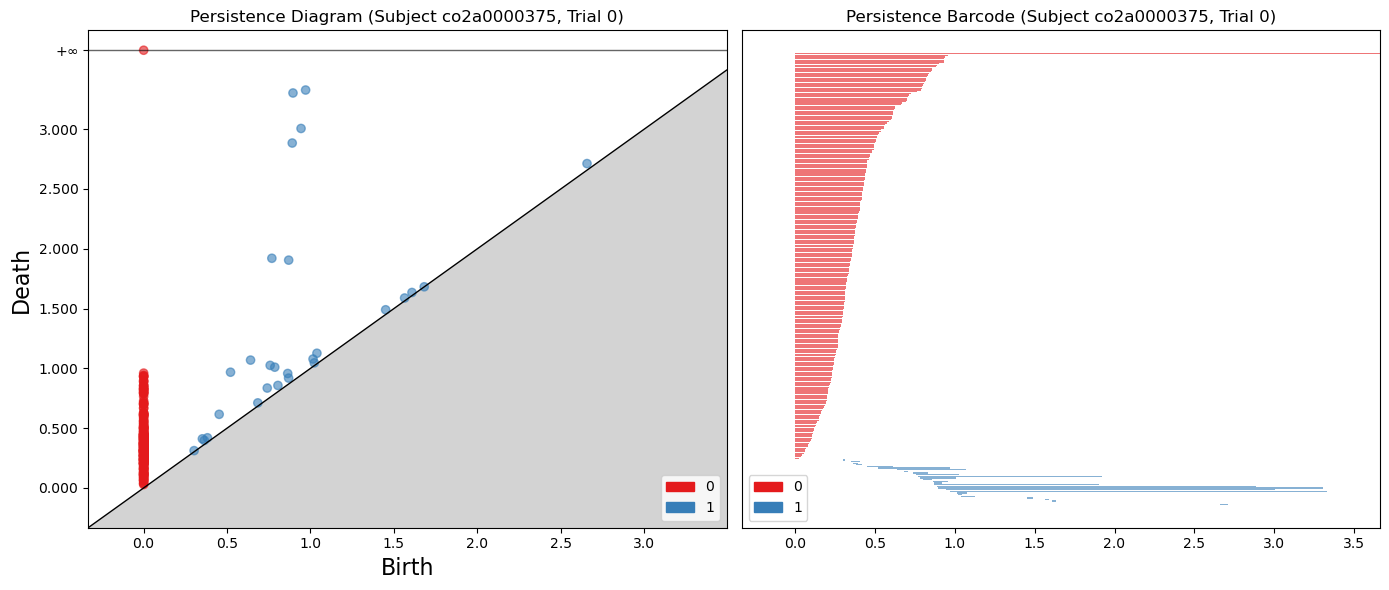

 50%|█████     | 235/468 [05:38<07:31,  1.94s/it]

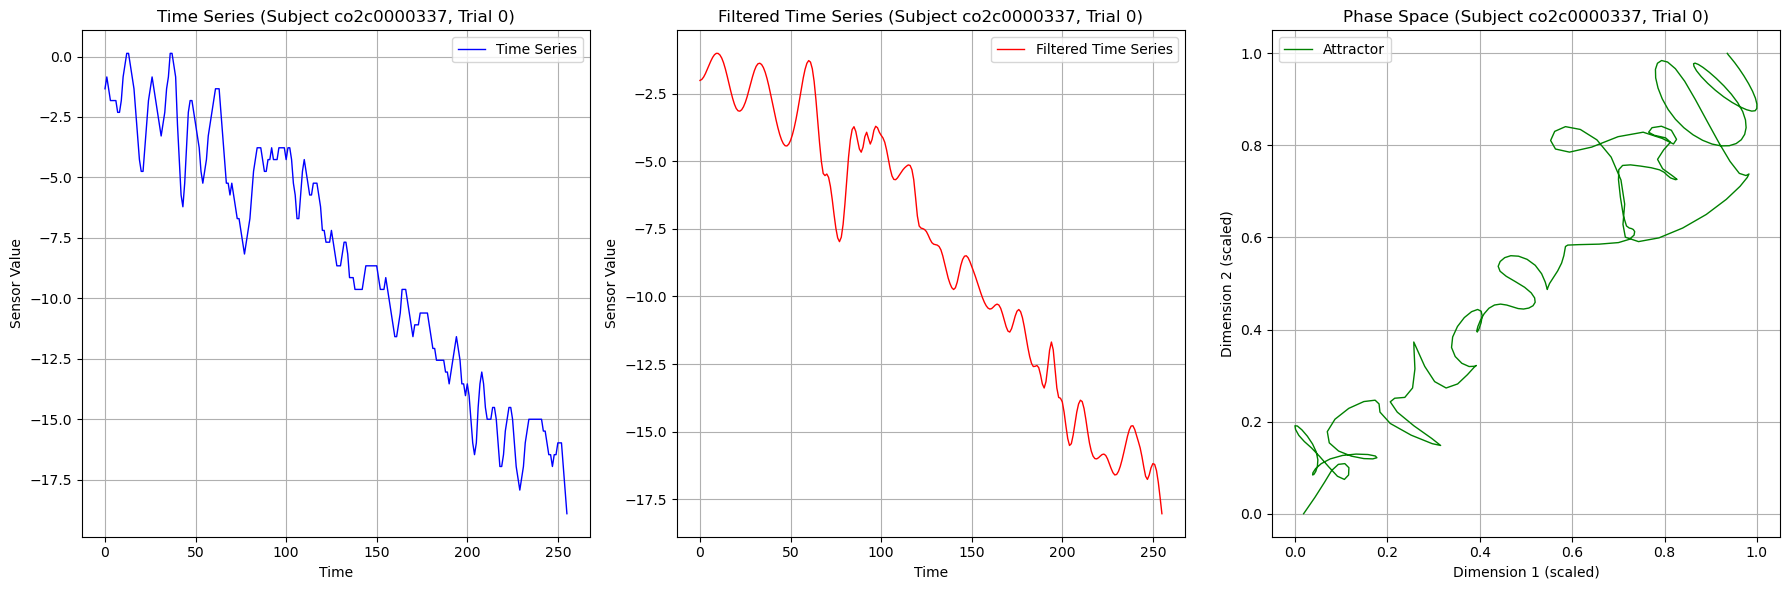

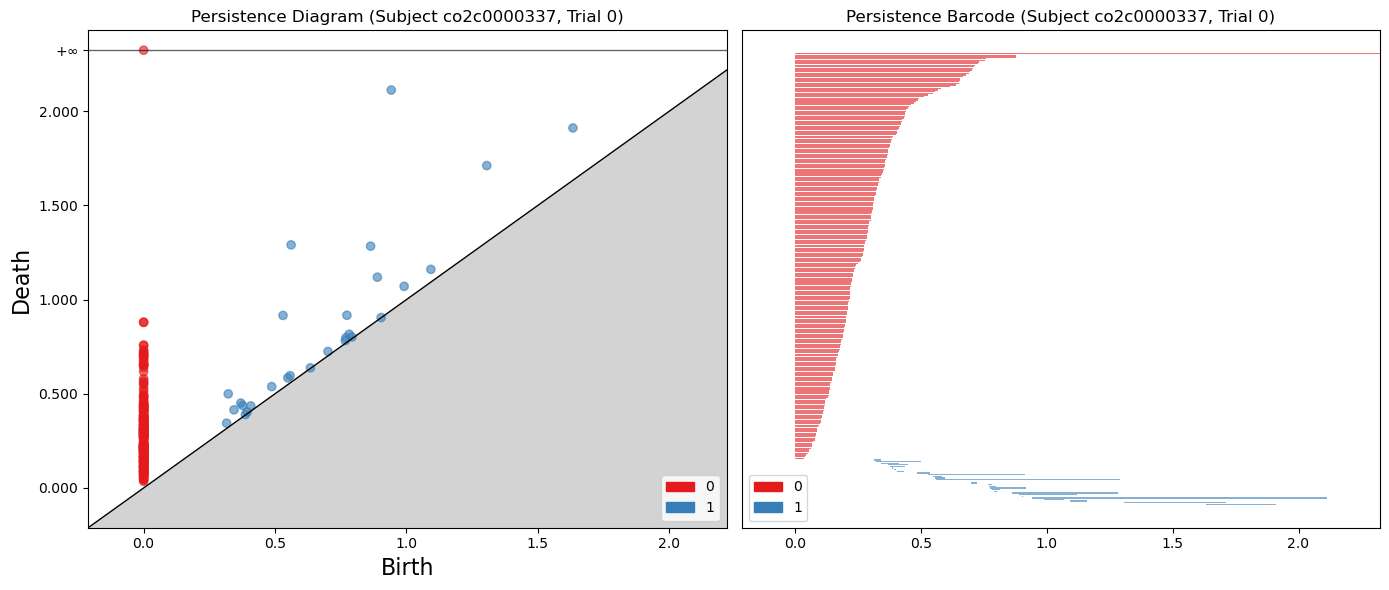

 57%|█████▋    | 265/468 [06:30<04:59,  1.48s/it]

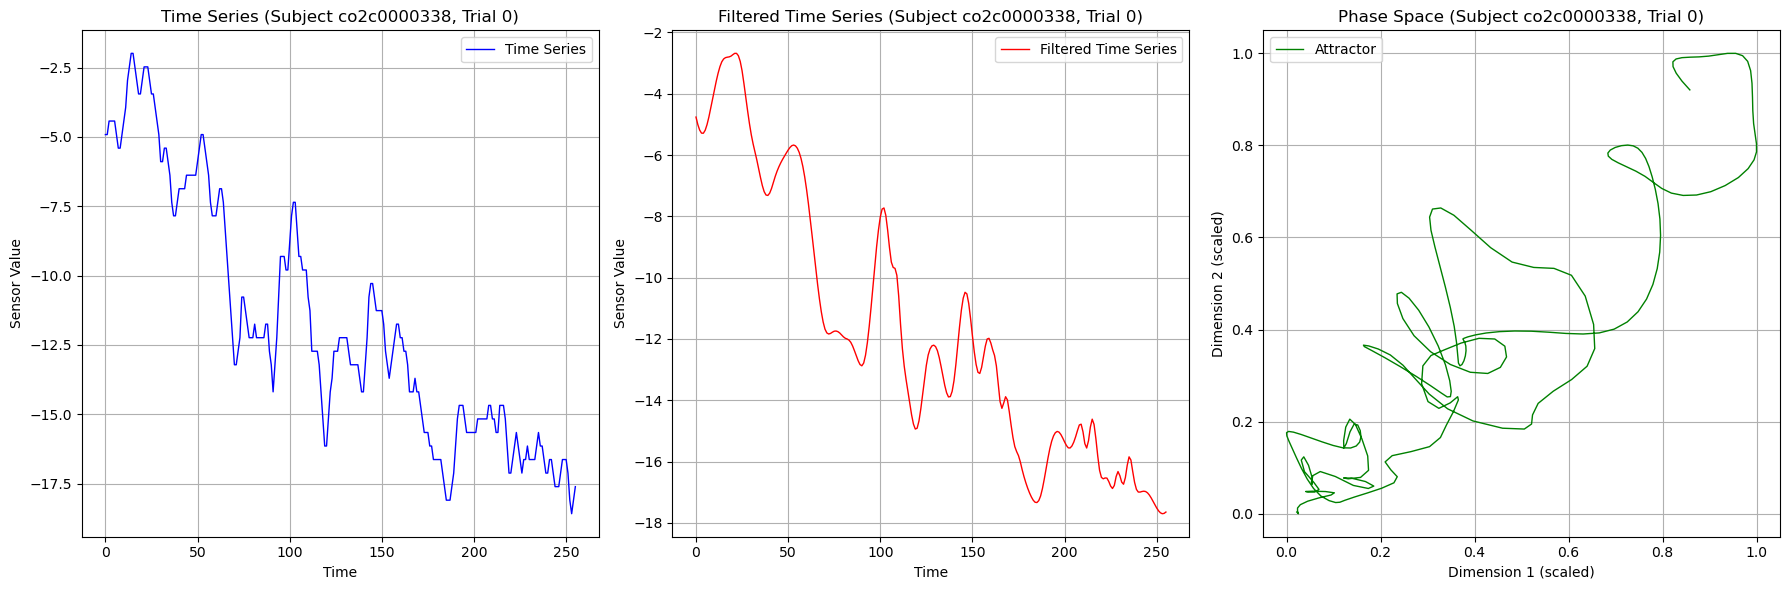

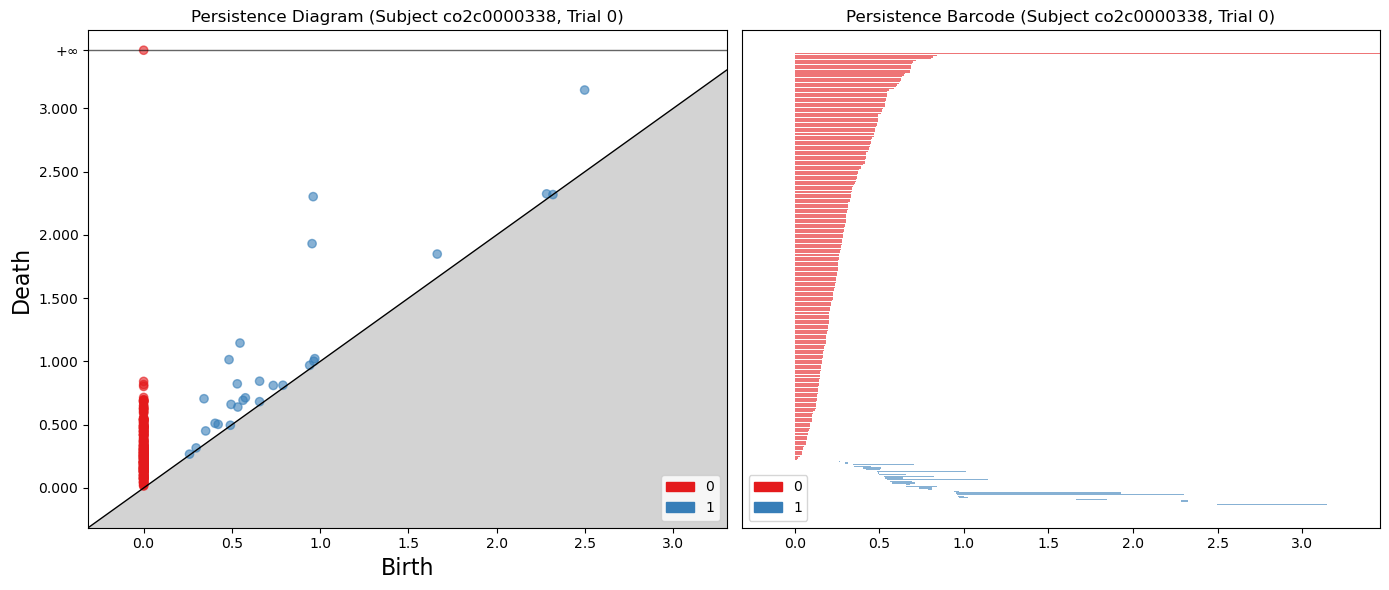

 63%|██████▎   | 294/468 [07:36<06:40,  2.30s/it]

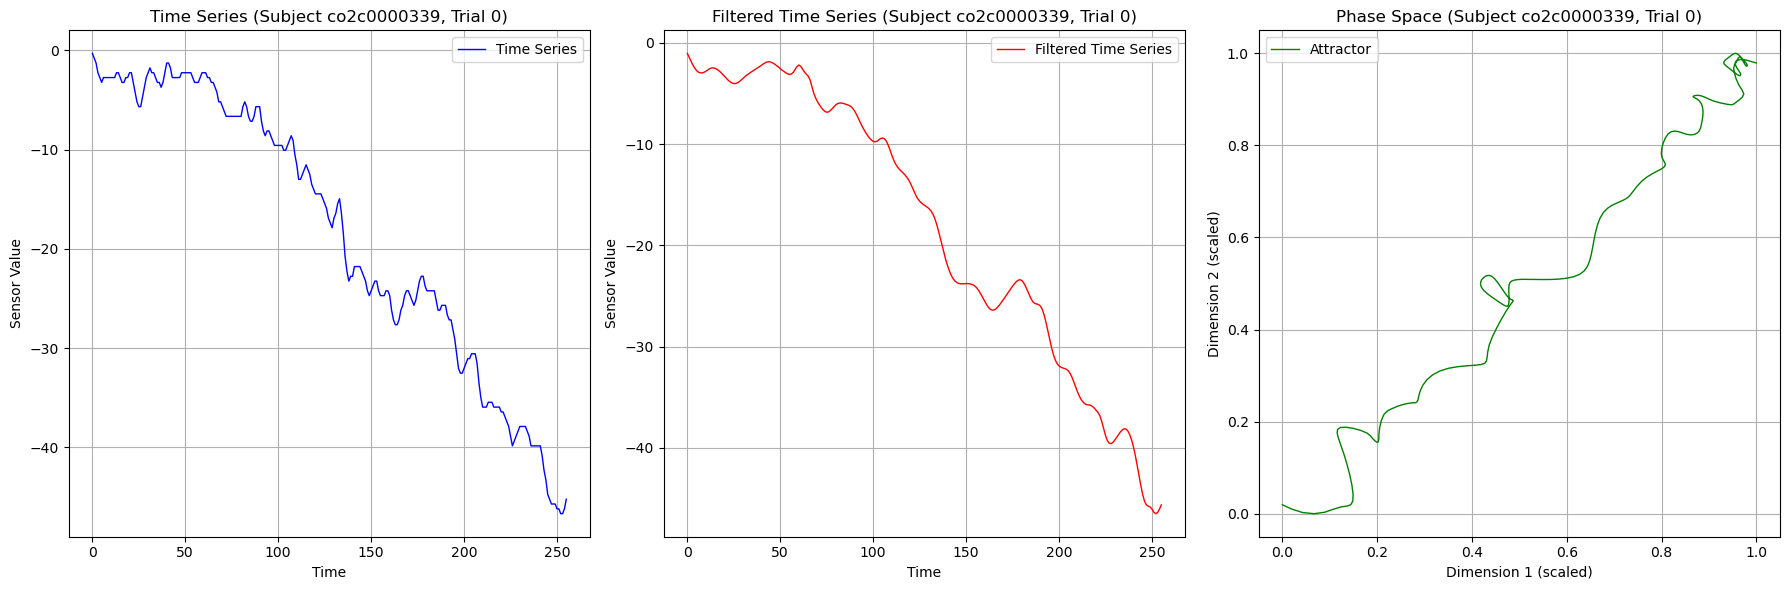

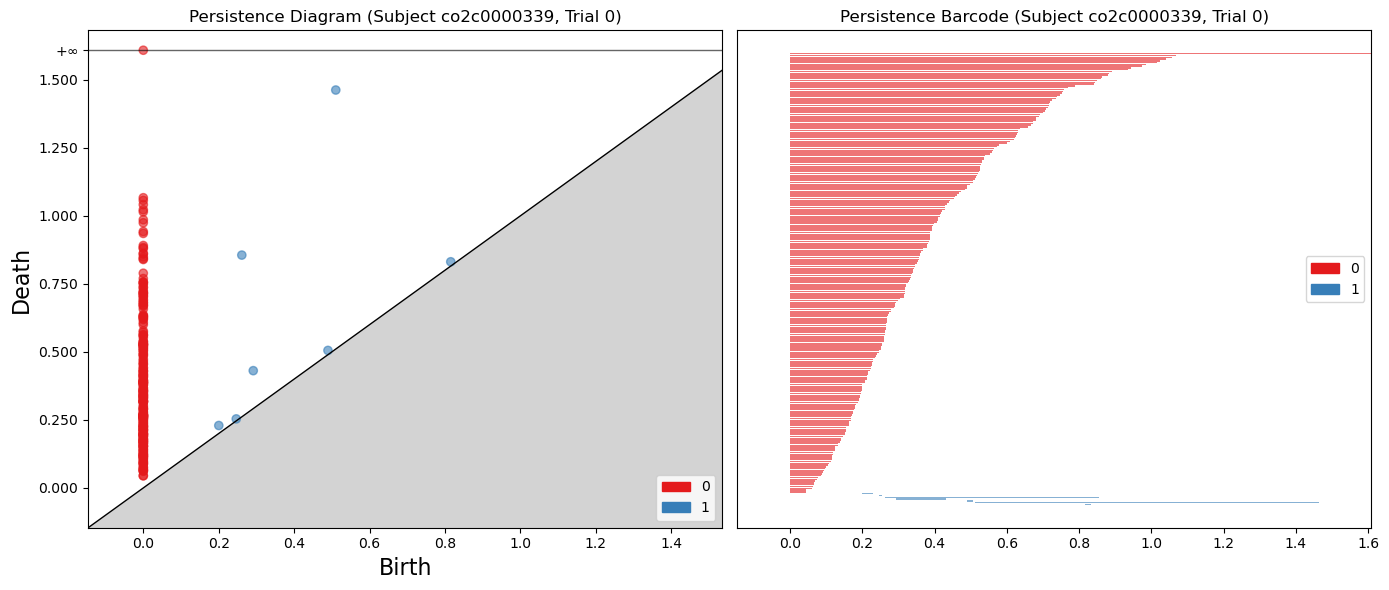

 69%|██████▉   | 324/468 [08:47<05:51,  2.44s/it]

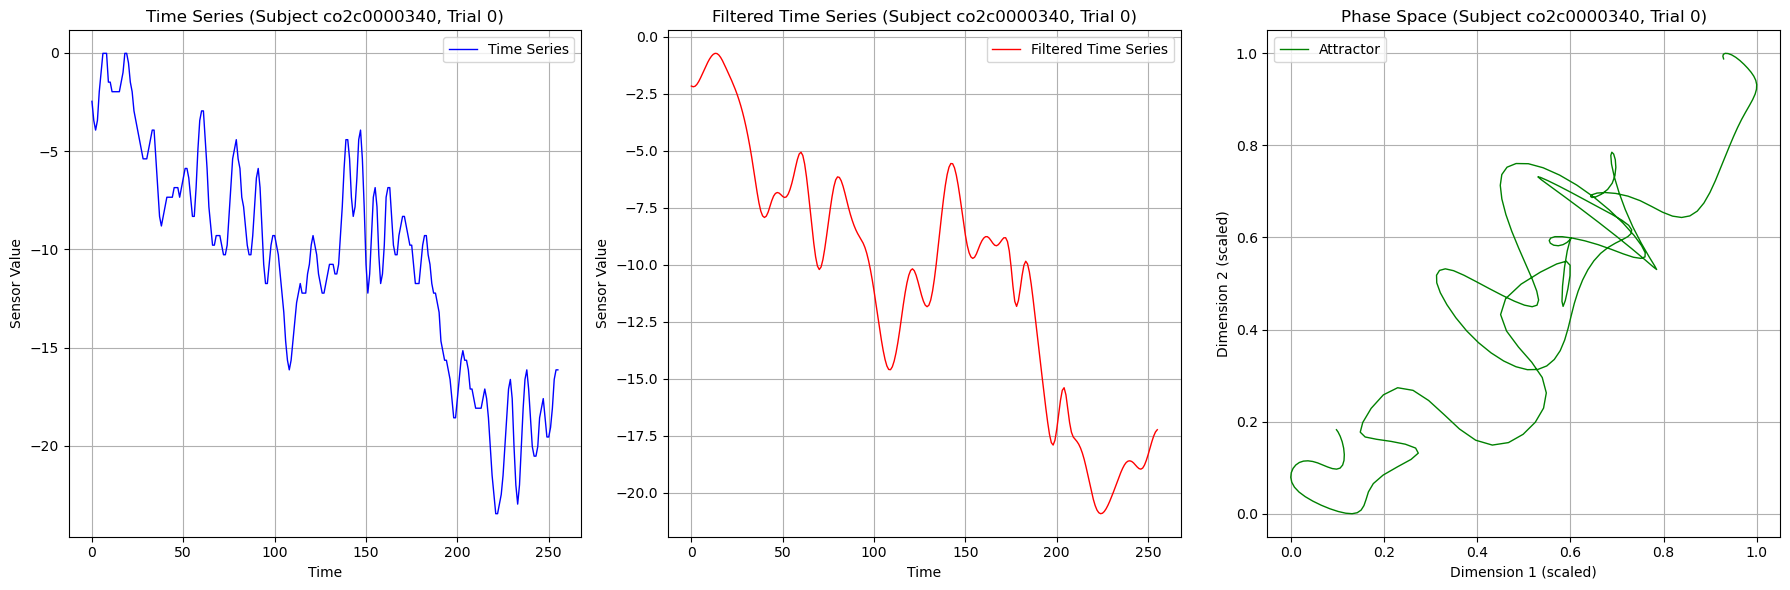

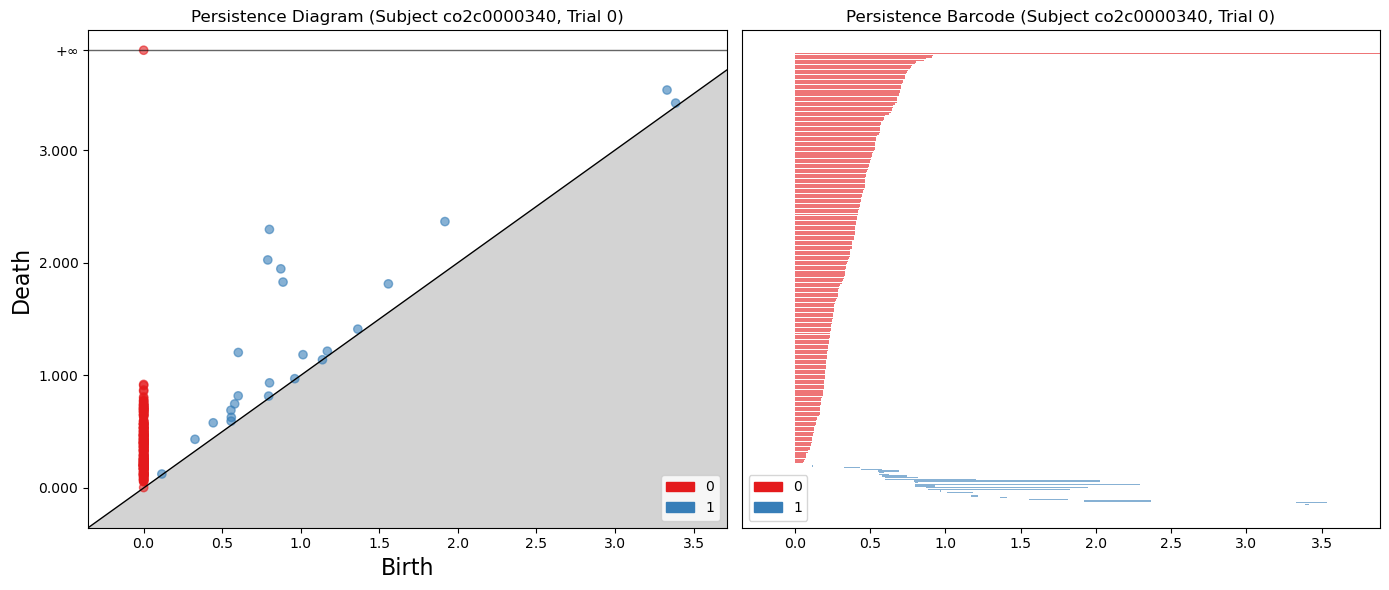

 75%|███████▌  | 353/468 [09:58<04:43,  2.46s/it]

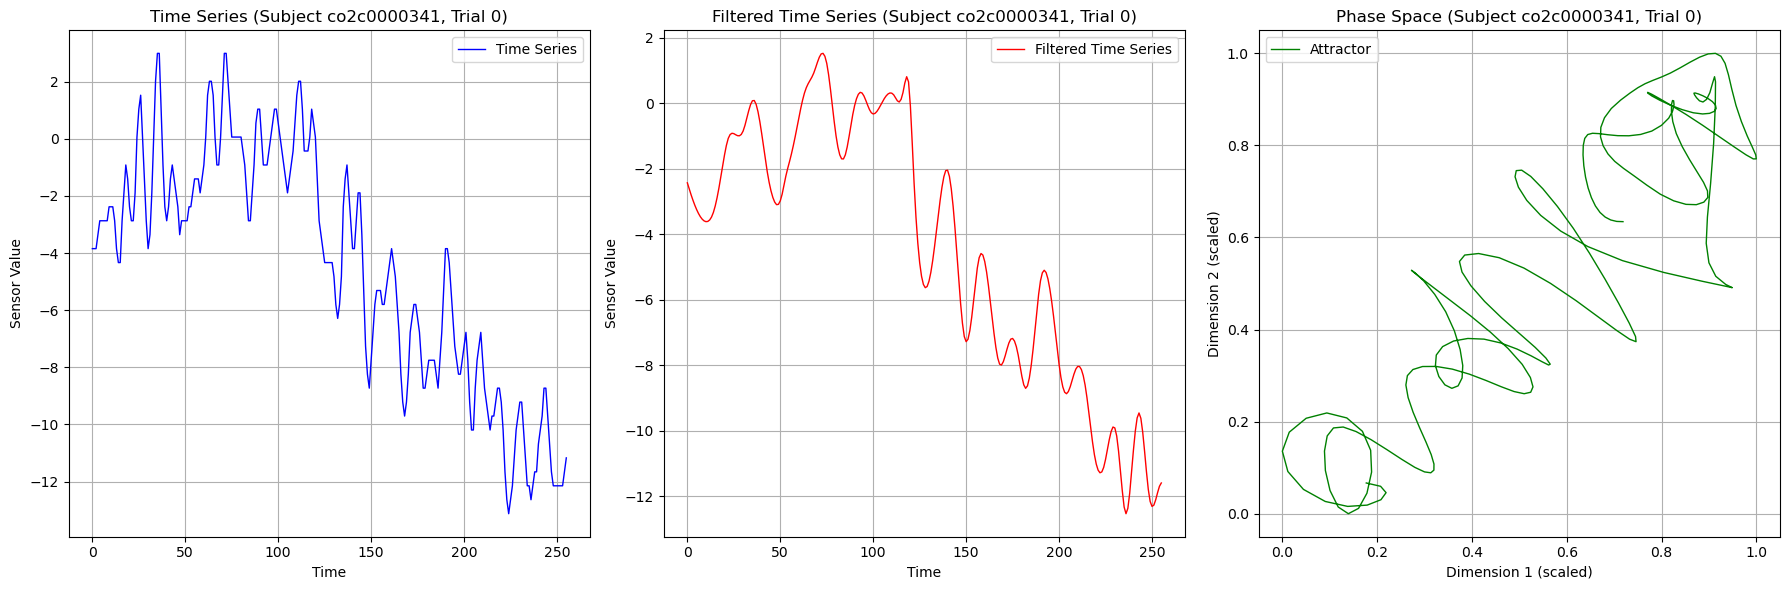

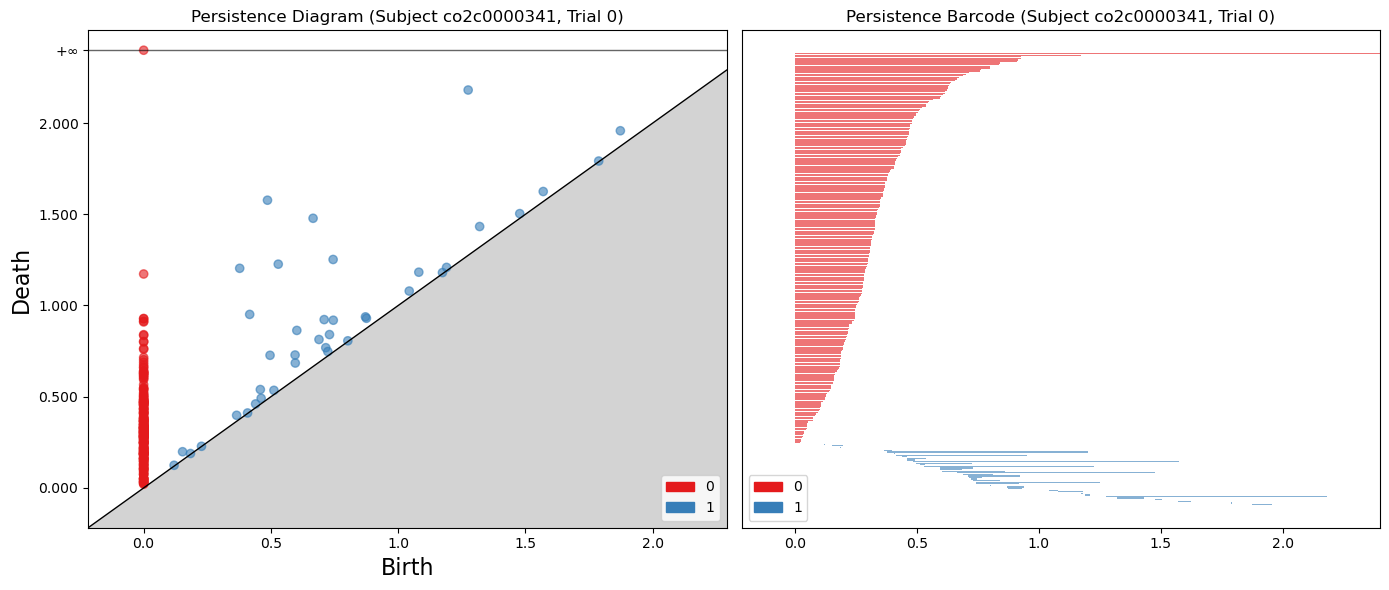

 81%|████████▏ | 381/468 [11:08<03:28,  2.40s/it]

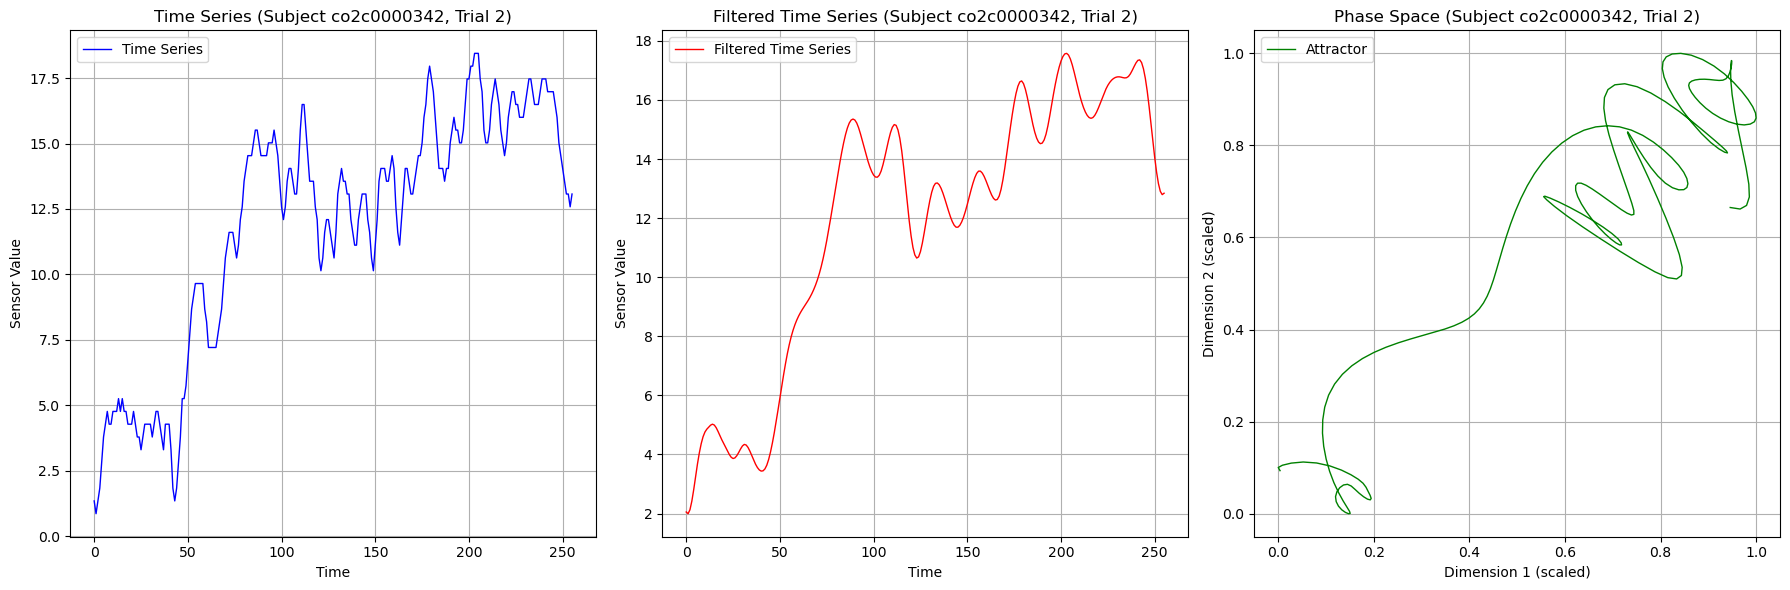

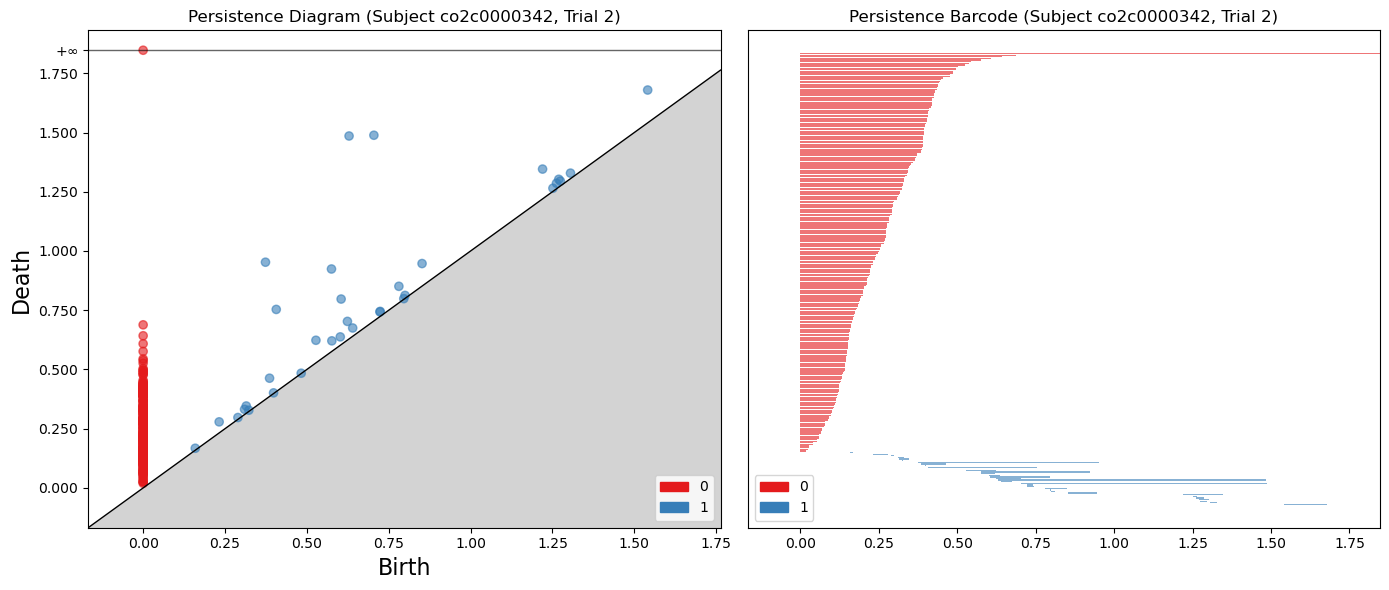

 88%|████████▊ | 410/468 [12:09<02:07,  2.19s/it]

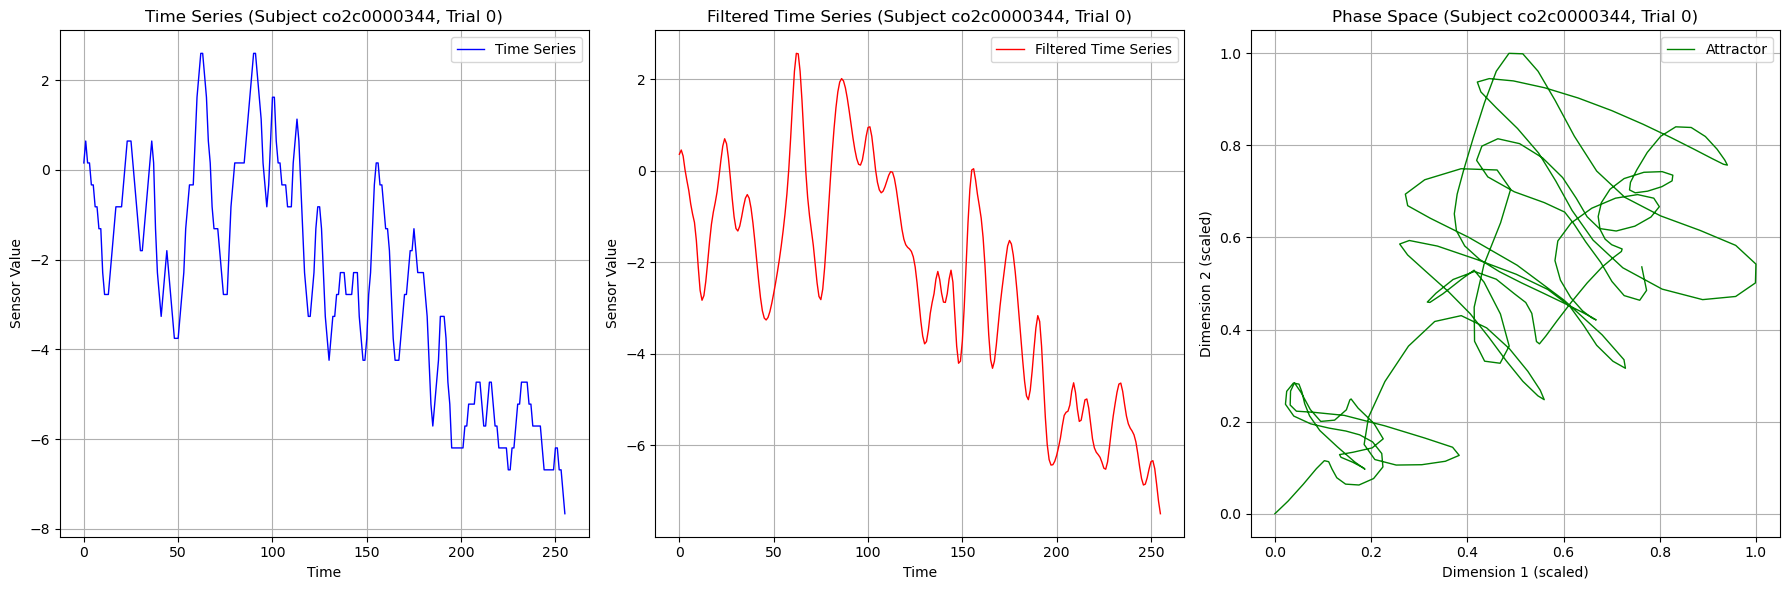

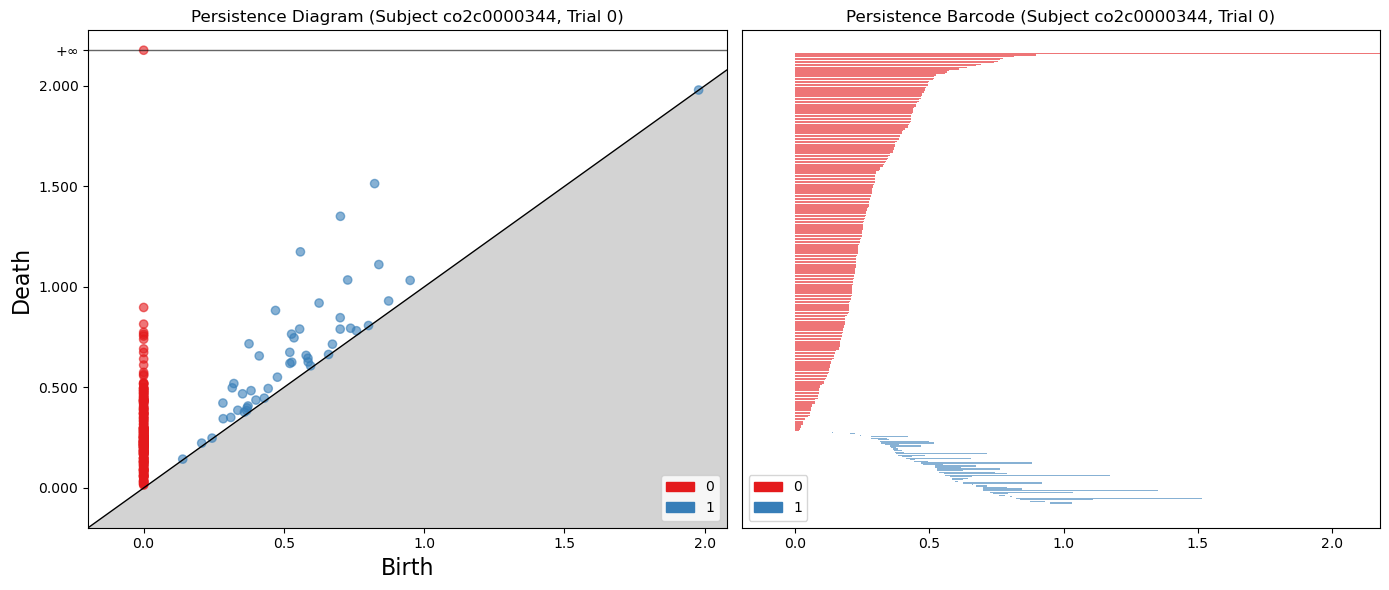

 94%|█████████▍| 439/468 [13:19<01:09,  2.41s/it]

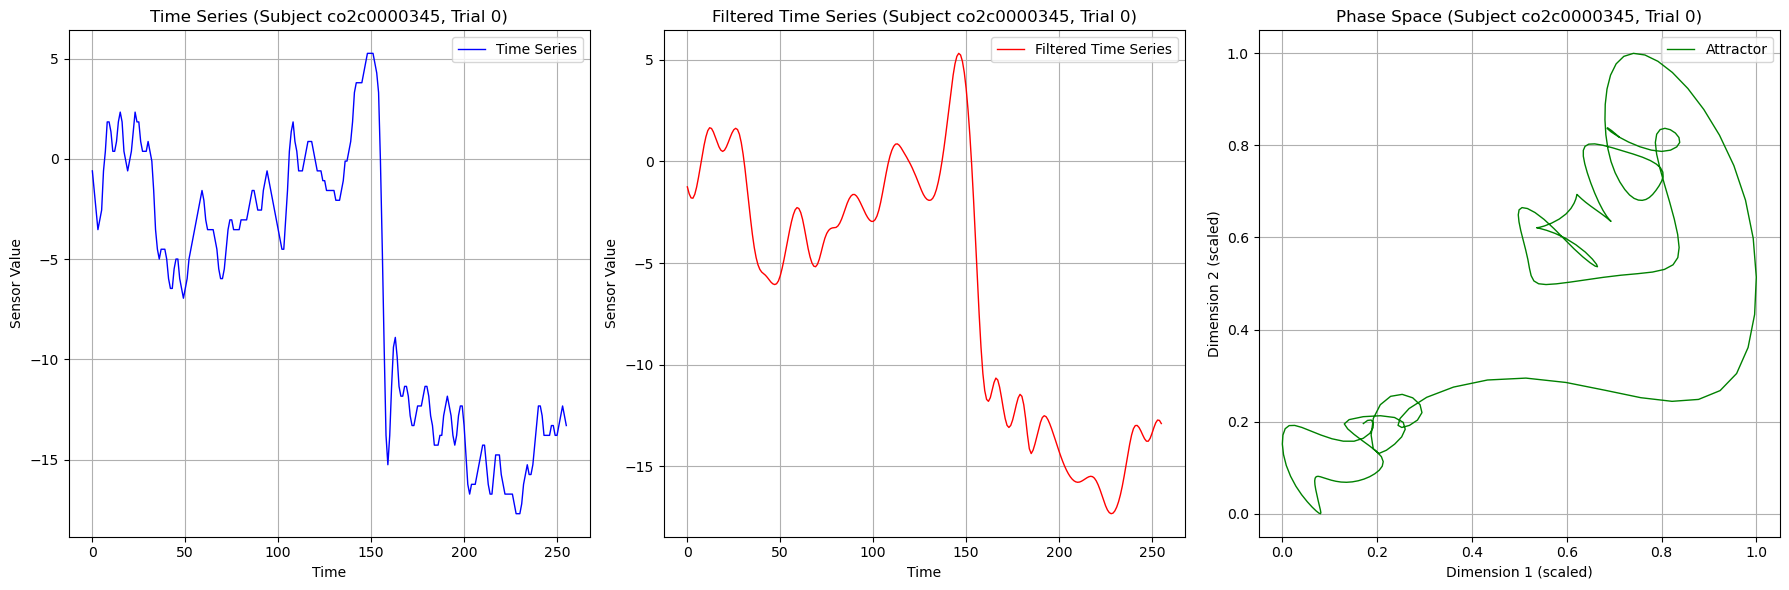

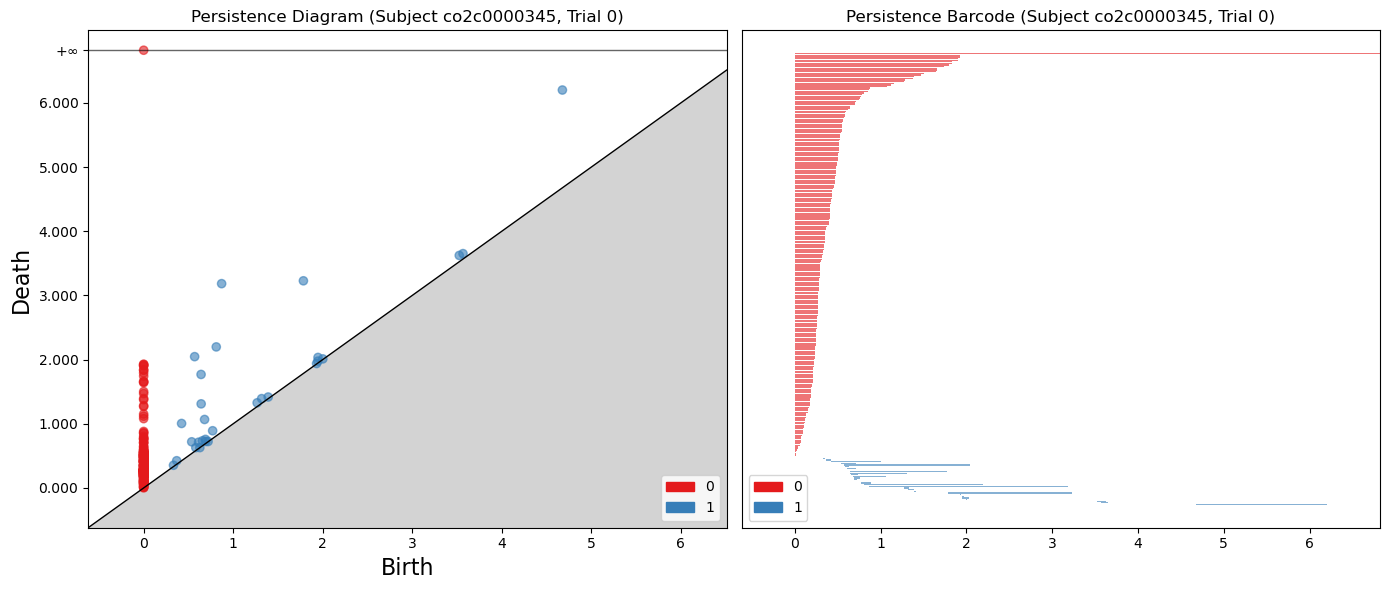

100%|██████████| 468/468 [14:26<00:00,  1.85s/it]
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\marti\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Accuracy: 0.56
Precision: 0.35
Recall: 0.31
F1 Score: 0.32
Mathews Correlation Coefficient: 0.00
              precision    recall  f1-score   support

           0       0.66      0.70      0.68       308
           1       0.35      0.31      0.32       160

    accuracy                           0.56       468
   macro avg       0.50      0.50      0.50       468
weighted avg       0.55      0.56      0.56       468



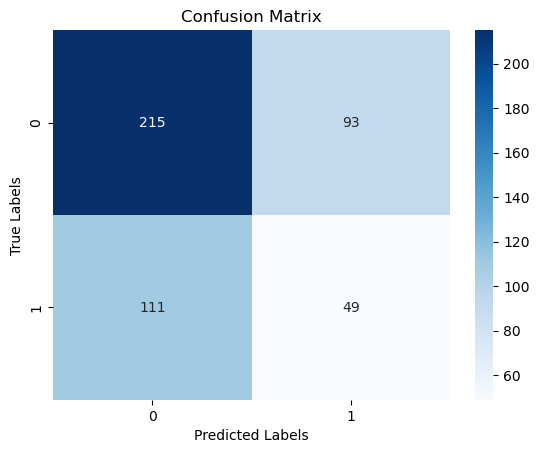

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,

In [36]:
features = []
labels = []

current_id = ""
for subject_id, group in tqdm(eeg_data.groupby(["name", "trial number"])):
    label = 0 if "a" in group["matching condition"].iloc[0] else 1
    labels.append(label)

    signal = group["sensor value"].values
    filtered_signal = apply_emd(signal)

    embedded_data = takens_embedding(filtered_signal, m=2, tau=10)

    if current_id != subject_id[0]: 
        plot_time_series_and_attractor(signal, filtered_signal, embedded_data, subject_id)

    persistence_diagram = compute_persistence_diagram_rips(embedded_data)
    
    if current_id != subject_id[0]: 
        plot_persistence_diagram_and_barcode(persistence_diagram, subject_id)
    
    current_id = subject_id[0]

    subject_features = extract_features(persistence_diagram)
    features.append(subject_features)

# Cluster and evaluate
features = np.array(features)
labels = np.array(labels)
cluster_and_evaluate(features, labels)